In [1]:
%run /Users/hhg/Research/kinematic_lensing/code/BinnedFit/GaussFit_spec2D.py
%run /Users/hhg/Research/kinematic_lensing/code/BinnedFit/ChainTool.py
%run /Users/hhg/Research/kinematic_lensing/code/BinnedFit/RotationCurveFit.py
%run /Users/hhg/Research/kinematic_lensing/code/BinnedFit/ChainTool.py

%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import numpy as np

sys.path.append("/Users/hhg/Research/kinematic_lensing/repo/kl_measurement/scripts/")
from parameter_class import fit_parameters
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import emcee
import chisq
from generate_TFcube import get_TFcube_pars, get_data_TFcube

sys.path.append("/Users/hhg/Research/kinematic_lensing/code/BinnedFit/")
from binnedFit_utilities import *

dir_tfCube: /Users/hhg/Research/kinematic_lensing/repo/KLens


In [2]:
def get_grid_velocity(grid_labmda, lambda_cen):
    grid_z = grid_labmda/lambda_cen - 1.
    c_kms = 299792.458
    grid_v = grid_z*c_kms
    return grid_v

In [3]:
sini = 0.761
g1 = 0.0
g2 = 0.2

eint_thy = cal_e_int(sini=sini)
eobs_thy = cal_e_obs(e_int=eint_thy, gamma_p=g1)
theta_obs = cal_theta_obs(e_int=eint_thy, gamma_x=g2)

slitAng_major_p = theta_obs    # 45./180.*np.pi
slitAng_minor_p = theta_obs + np.pi/2.

bestfit_e_obs = eobs_thy
print("eobs_thy:", eobs_thy)
print("slitAng_major_p:", slitAng_major_p*180./np.pi)
print("slitAng_minor_p:", slitAng_minor_p*180./np.pi)

eobs_thy: 0.38499950250817866
slitAng_major_p: 29.764079766240826
slitAng_minor_p: 119.76407976624081


In [4]:
update_TF, _ = get_TFcube_pars()
update_TF['redshift'] = 0.2

update_TF['slitAngles'] = np.array([slitAng_major_p, slitAng_minor_p])

update_TF['g1'] = g1
update_TF['g2'] = g2
update_TF['sini'] = sini

# update_TF['nm_per_pixel'] = 0.025 #0.033 # 0.025
# update_TF['pixScale'] = 0.032  # 0.1185  # 0.032 
# update_TF['Resolution'] = 6000.
# update_TF['psfFWHM'] = 0.5
# update_TF['throughput'] = 0.29
# update_TF['slitWidth'] = 0.05
# update_TF['slitOffset'] = 0.0
# update_TF['expTime'] = 10000.0 
# update_TF['area'] = 3.14*(1000./2.)**2

update_TF['nm_per_pixel'] = 0.025 #0.033 # 0.025
update_TF['pixScale'] = 0.032 # 0.1185  # 0.032 
update_TF['Resolution'] = 6000.
update_TF['psfFWHM'] = 0.05
update_TF['throughput'] = 0.29
update_TF['slitWidth'] = 0.01
update_TF['expTime'] = 10000.0 
update_TF['area'] = 3.14*(1000./2.)**2


update_TF['linelist']['flux'][update_TF['linelist']['species'] == 'Halpha'] = 6.0e-24
update_TF['norm'] = 0.
update_TF['lambda_min'] = (1 + update_TF['redshift']) * update_TF['linelist']['lambda'][update_TF['linelist']['species'] == 'Halpha'] - 2
update_TF['lambda_max'] = (1 + update_TF['redshift']) * update_TF['linelist']['lambda'][update_TF['linelist']['species'] == 'Halpha'] + 2


update_TF['vcirc'] = 200. 
update_TF['aspect'] = 0.2
update_TF['n_knots'] = 25.
update_TF['knot_fraction'] = 0.0
update_TF['half_light_radius'] = 0.5
update_TF['vscale'] = update_TF['half_light_radius']

update_TF['ngrid'] = 512
update_TF['image_size'] = 256

update_TF['type_of_observation'] = 'slit'

TF_pars, meta_parameters = get_TFcube_pars(update_TF)

%time data, noise, obslambda = get_data_TFcube(TF_pars, meta_parameters, return_lambda=True)

# make data_info from Prangal's data output

data_info = {}
data_info['ModelCube'] = None
data_info['ObsCube'] = None
data_info['image'] = data['image']
data_info['image_variance'] = noise['image']

if len(TF_pars['slitAngles']) == 1:
    data_info['data'] = data['spectra'][0]
else:
    #data_info['data'] = data['spectra'][0] # this line is to make it compatible with older branches... 
    data_info['data_major'] = data['spectra'][0]
    data_info['data_minor'] = data['spectra'][1]
    
data_info['grid_lambda'] = obslambda

extent =  TF_pars['image_size'] * TF_pars['pixScale']
subGridPixScale = extent*1./TF_pars['ngrid']

data_info['grid_pos']  = np.arange(-extent/2., extent/2., subGridPixScale)
data_info['grid_Image'] = np.arange(-extent/2., extent/2., TF_pars['pixScale'])
data_info['par_fid']   = TF_pars
data_info['lambda_emit'] = 656.461 # Halpha [nm]

returning:
lambda, observation, model, sky (the last three are (npix, npix, nspax) datacubes)
in new
in new
CPU times: user 1min 13s, sys: 1.11 s, total: 1min 14s
Wall time: 39.8 s


# 2D spec - major

In [5]:
# init Fit tool
RotFit = RotationCurveFit(data_info, active_par_key = ['r_0', 'v_spec', 'v_0', 'vscale'], data_key="data_major") #

params_rot = RotFit.optFit_rotation_curve(RotFit.gaussfit_peakLambda, par_init_guess={'vscale':0.5})
print(params_rot)

time cost in gaussFit_spec2D: 0.46155714988708496 (secs)
{'vscale': 0.5232017755561544, 'r_0': -0.0024335765887761656, 'v_spec': 127.77287546088112, 'v_0': -0.40030580035103314, 'redshift': 0.19999999983046046}


In [6]:
# find fitting parameters using MCMC (get error bars as well)
chain_info = RotFit.run_MCMC(Nwalker=100, Nsteps=3000)
Chain = ChainTool(chain_info, Nburn=150000, Nend=300000)

100%|██████████| 3000/3000 [00:12<00:00, 239.55it/s]

Total MCMC time (mins): 0.20891841650009155


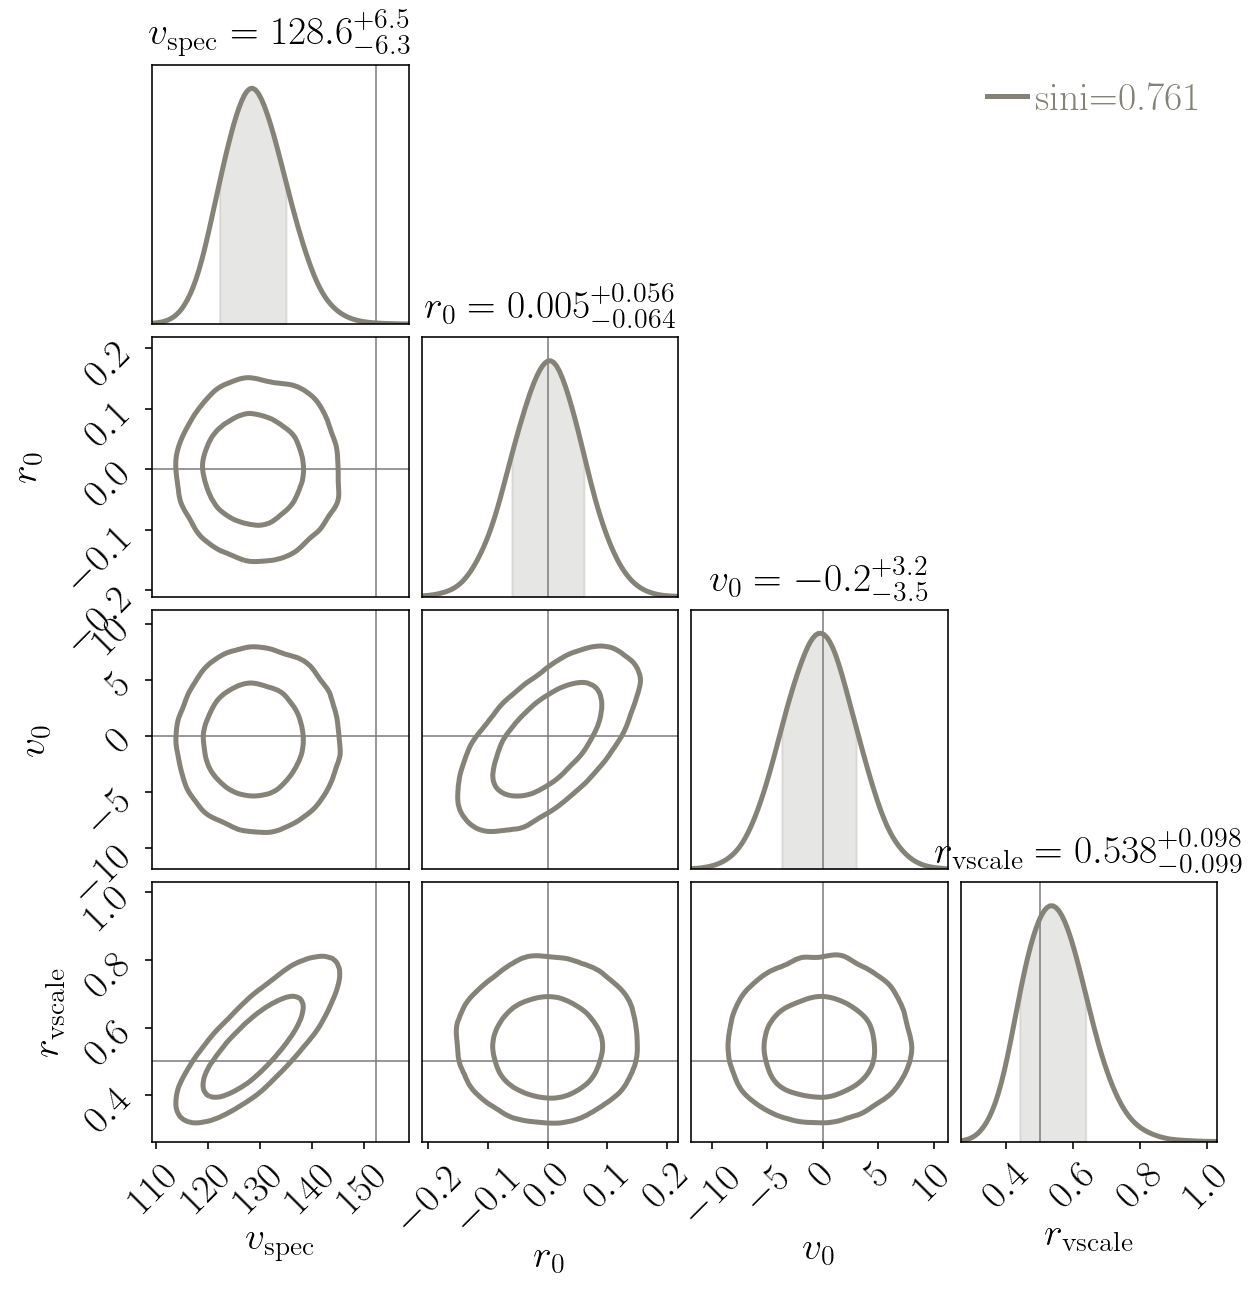

In [7]:
Nchains = 1
colors = [gray, lightblue, red, yellow, blue, yellowgreen, green, green, black]
lines = ["-", '--', "--", "-.", '-', ":", "--", ':']

statistics="max"

select_par_key = ['v_spec', 'r_0', 'v_0', 'vscale'] #, 'vscale'
legend_chain = "sini=%.3f"%sini

parID1,parName1,par_x1 = Chain.select_par_info(select_par_key)

c = ChainConsumer()
c.add_chain(Chain.chain[:, parID1]       , parameters=parName1 ,name=legend_chain)

c.configure(linewidths=2.5,sigmas=np.array([0,1,2]),bins=0.5,sigma2d=False,label_font_size=20,tick_font_size=20
            ,colors=colors
            ,shade=[False]*Nchains
            ,statistics=statistics,summary=True
            ,linestyles=lines
            ,shade_gradient=[0]*Nchains
            ,bar_shade=[True]*Nchains)

c.configure_truth(color="gray",lw=1,ls="-",alpha=0.8, zorder=-1)
fig = c.plotter.plot(legend=True, truth=par_x1)

fig.subplots_adjust(left=0.12, right=0.99, bottom=0.11, top=0.99)

fig.set_size_inches(2.5 + fig.get_size_inches())
fig.savefig("fig1.pdf", transparent=True)

In [8]:
data_info_major = data_info.copy()
data_info_major['data'] = data['spectra'][0]

GaussFit = GaussFit_spec2D(data_info_major)

fitted_peakLambda, fitted_amp, fitted_sigma = GaussFit.gaussFit_spec2D(data=GaussFit.data)
model = GaussFit.model_spec2D(fitted_peakLambda,fitted_amp,fitted_sigma)
data = GaussFit.data

# get pixel edges
lambda_min = np.min(GaussFit.grid_lambda)  ; lambda_MAX = np.max(GaussFit.grid_lambda)
x_min = np.min(GaussFit.grid_pos)          ; x_MAX = np.max(GaussFit.grid_pos)

lambda_cen = data_info_major['lambda_emit']*(1.+data_info_major['par_fid']['redshift'])

grid_velocity = get_grid_velocity(grid_labmda=GaussFit.grid_lambda, lambda_cen=lambda_cen)

time cost in gaussFit_spec2D: 0.46222496032714844 (secs)


In [9]:
fitted_peakVelocity = get_grid_velocity(grid_labmda=fitted_peakLambda, lambda_cen=lambda_cen)

fitted_lambda_up = fitted_peakLambda+fitted_sigma
fitted_lambda_lo = fitted_peakLambda-fitted_sigma

fitted_velocity_lo = get_grid_velocity(grid_labmda=fitted_lambda_up, lambda_cen=lambda_cen) - fitted_peakVelocity
fitted_velocity_up = fitted_peakVelocity - get_grid_velocity(grid_labmda=fitted_lambda_lo, lambda_cen=lambda_cen) 

fitted_velocity_error = np.vstack((fitted_velocity_lo, fitted_velocity_up))
fitted_velocity_error.shape

(2, 512)

Text(0, 0.5, 'v [km/s]')

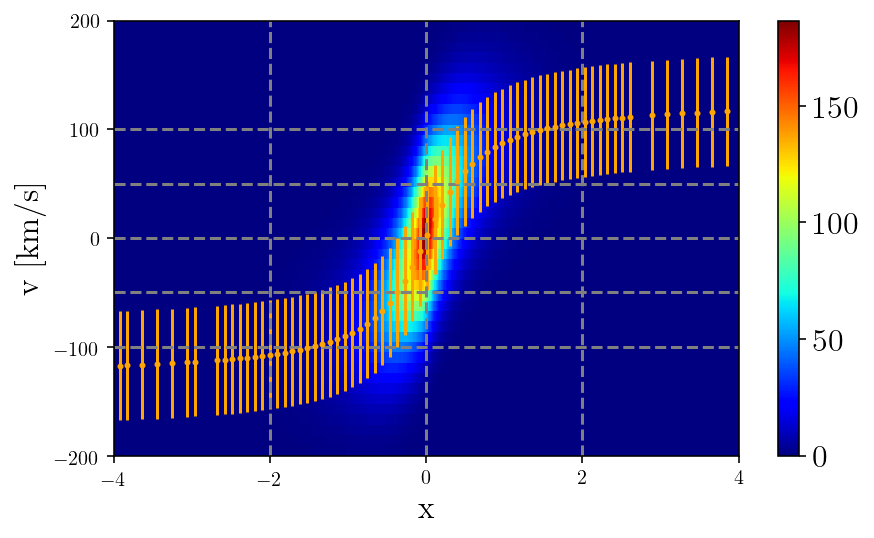

In [10]:
#%matplotlib
%matplotlib inline

ncol=1

fig,ax = plt.subplots(1,1,figsize=(7,4))
plt.rc('font',size=16)

POS, VEL = np.meshgrid(GaussFit.grid_pos, grid_velocity)  # VEL, POS = np.meshgrid(grid_velocity, GaussFit.grid_pos)
img0=ax.pcolormesh(POS, VEL, data.T, cmap='jet')          # img0 = ax.pcolormesh(POS, VEL, data, cmap='Greys')

#### gaussfit image peak identification summary (yellow)
ax.errorbar(GaussFit.grid_pos[5::6], fitted_peakVelocity[5::6], yerr = fitted_velocity_error[:,5::6], color='orange', marker='o', markersize=2, ls='none', label='gauss1D fit on 2D spec')

ax.axhline(0., color='gray',ls='--')
ax.axhline(100., color='gray',ls='--')
ax.axhline(-100., color='gray',ls='--')
ax.axvline(0., color='gray',ls='--')
ax.axvline(2., color='gray',ls='--')
ax.axvline(-2., color='gray',ls='--')
ax.axhline(50., color='gray',ls='--')
ax.axhline(-50., color='gray',ls='--')

fig.colorbar(img0, ax=ax)
ax.set_xlim((-4, 4))
ax.set_ylim((-200., 200.))

ax.set_xlabel('x', fontsize=16)
ax.set_ylabel('v [km/s]', fontsize=16)

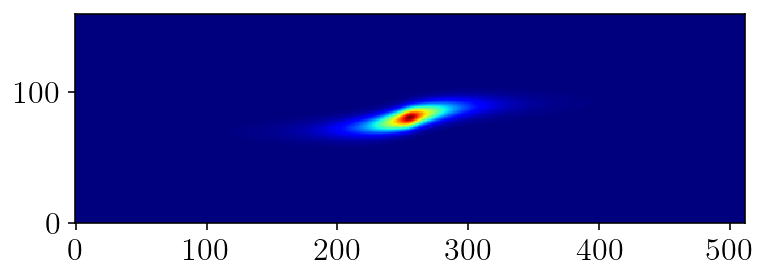

In [11]:
plt.imshow(data.T,cmap=plt.cm.jet, origin='lower')

In [12]:
POS, VEL = np.meshgrid(GaussFit.grid_pos, grid_velocity)

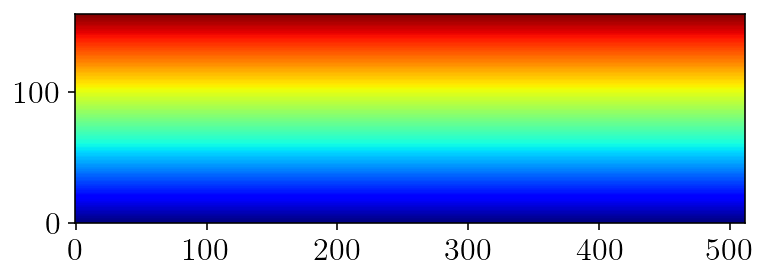

In [13]:
plt.imshow(VEL,cmap=plt.cm.jet, origin='lower')

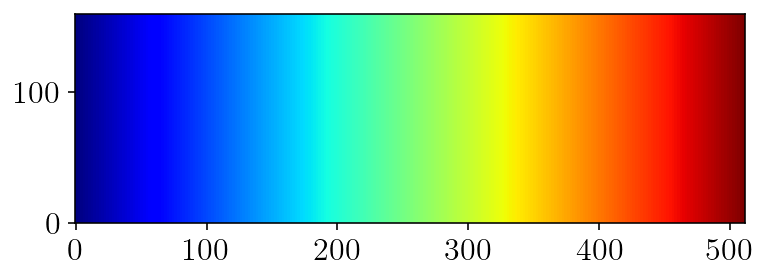

In [14]:
plt.imshow(POS,cmap=plt.cm.jet, origin='lower')

# 2D spec - minor

In [15]:
# init Fit tool
RotFit_minor = RotationCurveFit(data_info, active_par_key = ['r_0', 'v_spec', 'v_0', 'vscale'], data_key="data_minor") #

params_rot_minor = RotFit_minor.optFit_rotation_curve(RotFit_minor.gaussfit_peakLambda, par_init_guess={'vscale':0.5})
print(params_rot_minor)

time cost in gaussFit_spec2D: 0.4534778594970703 (secs)
{'vscale': 0.2929881036141169, 'r_0': -0.016833429193953395, 'v_spec': -62.38128314936929, 'v_0': -0.28353646958854106, 'redshift': 0.19999999165564514}


In [16]:
# find fitting parameters using MCMC (get error bars as well)
chain_info_minor = RotFit_minor.run_MCMC(Nwalker=100, Nsteps=3000)
Chain_minor = ChainTool(chain_info_minor, Nburn=150000, Nend=300000)

100%|██████████| 3000/3000 [00:13<00:00, 220.19it/s]

Total MCMC time (mins): 0.22721160252888997


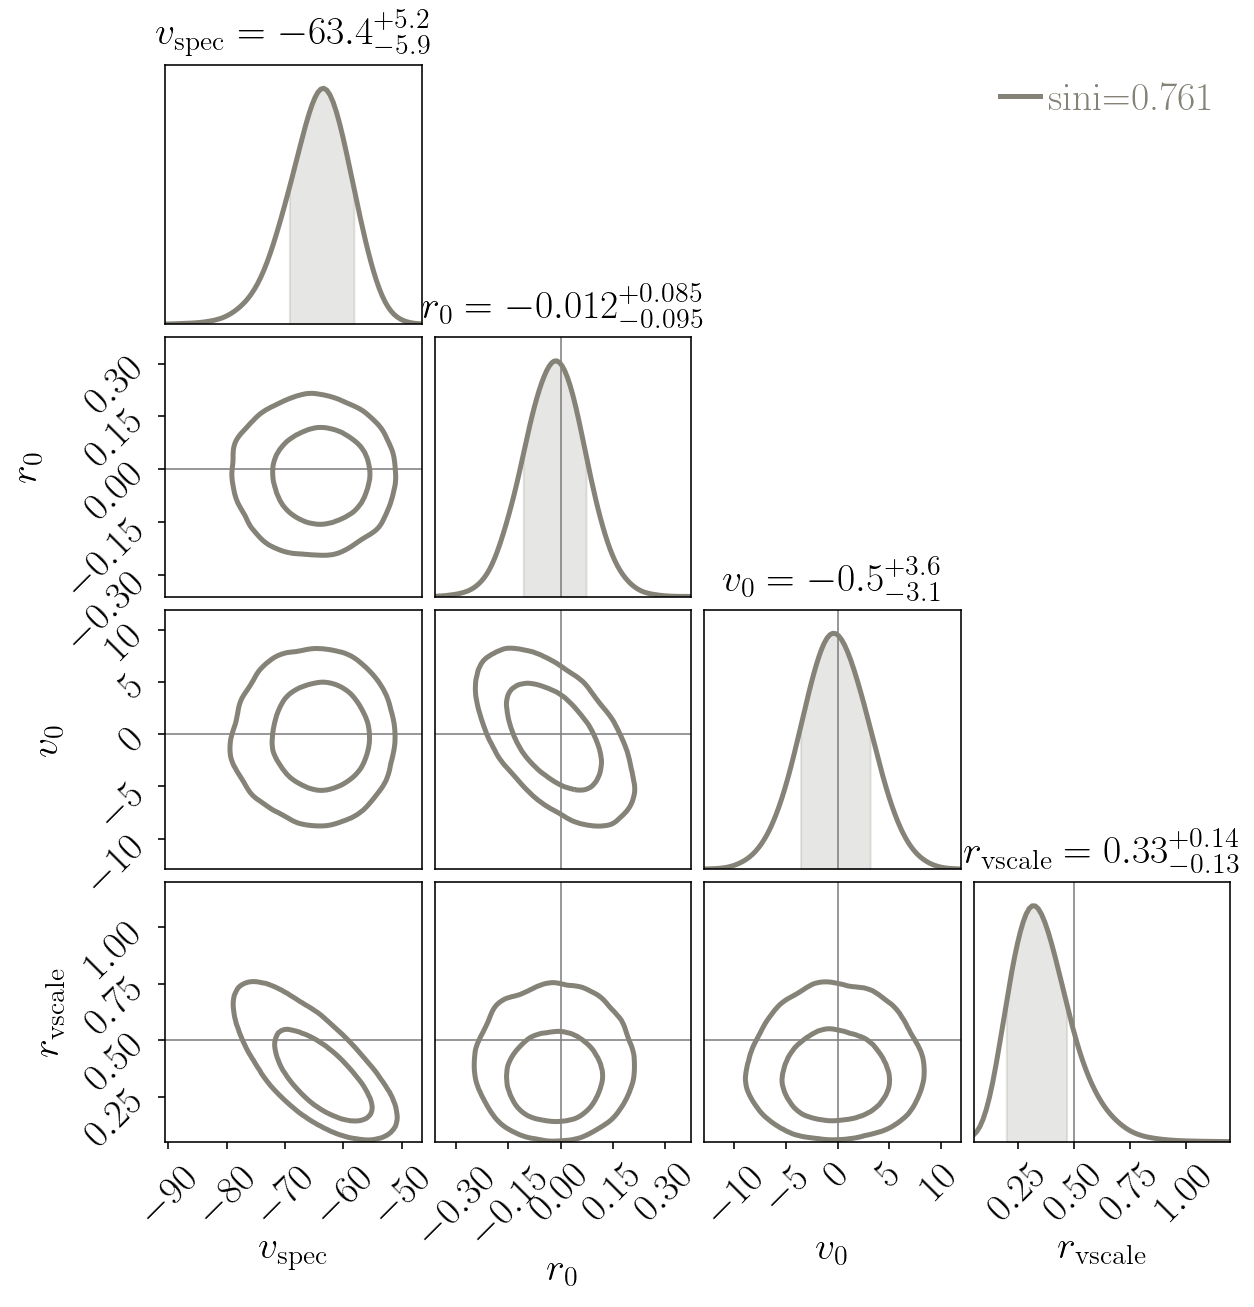

In [17]:
Nchains = 1
colors = [gray, lightblue, red, yellow, blue, yellowgreen, green, green, black]
lines = ["-", '--', "--", "-.", '-', ":", "--", ':']

statistics="max"

select_par_key = ['v_spec', 'r_0', 'v_0', 'vscale'] #, 'vscale'
legend_chain = "sini=%.3f"%sini

parID1,parName1,par_x1 = Chain_minor.select_par_info(select_par_key)

c = ChainConsumer()
c.add_chain(Chain_minor.chain[:, parID1] , parameters=parName1 ,name=legend_chain)

c.configure(linewidths=2.5,sigmas=np.array([0,1,2]),bins=0.5,sigma2d=False,label_font_size=20,tick_font_size=20
            ,colors=colors
            ,shade=[False]*Nchains
            ,statistics=statistics,summary=True
            ,linestyles=lines
            ,shade_gradient=[0]*Nchains
            ,bar_shade=[True]*Nchains)

c.configure_truth(color="gray",lw=1,ls="-",alpha=0.8, zorder=-1)
fig = c.plotter.plot(legend=True, truth=par_x1)

fig.subplots_adjust(left=0.12, right=0.99, bottom=0.11, top=0.99)

fig.set_size_inches(2.5 + fig.get_size_inches())
fig.savefig("fig1.pdf", transparent=True)

In [18]:
data_info_minor = data_info.copy()
data_info_minor['data'] = data_info_minor['data_minor']

GaussFit = GaussFit_spec2D(data_info_minor)

fitted_peakLambda, fitted_amp, fitted_sigma = GaussFit.gaussFit_spec2D(data=GaussFit.data)
model = GaussFit.model_spec2D(fitted_peakLambda,fitted_amp,fitted_sigma)
data = GaussFit.data

# get pixel edges
lambda_min = np.min(GaussFit.grid_lambda)  ; lambda_MAX = np.max(GaussFit.grid_lambda)
x_min = np.min(GaussFit.grid_pos)          ; x_MAX = np.max(GaussFit.grid_pos)

lambda_cen = data_info_minor['lambda_emit']*(1.+data_info_minor['par_fid']['redshift'])

grid_velocity = get_grid_velocity(grid_labmda=GaussFit.grid_lambda, lambda_cen=lambda_cen)

time cost in gaussFit_spec2D: 0.5060217380523682 (secs)


In [19]:
fitted_peakVelocity = get_grid_velocity(grid_labmda=fitted_peakLambda, lambda_cen=lambda_cen)

fitted_lambda_up = fitted_peakLambda+fitted_sigma
fitted_lambda_lo = fitted_peakLambda-fitted_sigma

fitted_velocity_lo = get_grid_velocity(grid_labmda=fitted_lambda_up, lambda_cen=lambda_cen) - fitted_peakVelocity
fitted_velocity_up = fitted_peakVelocity - get_grid_velocity(grid_labmda=fitted_lambda_lo, lambda_cen=lambda_cen) 

fitted_velocity_error = np.vstack((fitted_velocity_lo, fitted_velocity_up))
fitted_velocity_error.shape

(2, 512)

Text(0, 0.5, 'v [km/s]')

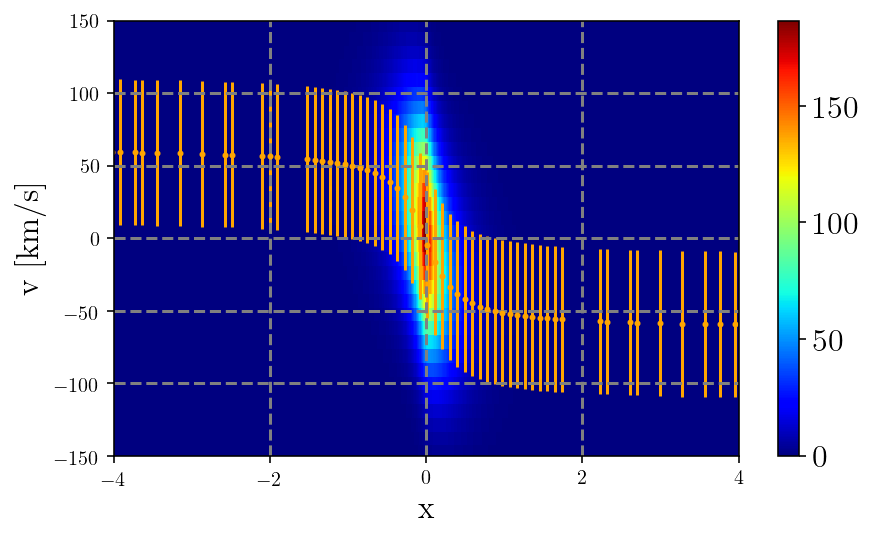

In [20]:
#%matplotlib
%matplotlib inline

ncol=1

fig,ax = plt.subplots(1,1,figsize=(7, 4))
plt.rc('font',size=16)

POS, VEL = np.meshgrid(GaussFit.grid_pos, grid_velocity)  # VEL, POS = np.meshgrid(grid_velocity, GaussFit.grid_pos)
img0=ax.pcolormesh(POS, VEL, data.T, cmap='jet')          # img0 = ax.pcolormesh(POS, VEL, data, cmap='Greys')

#### gaussfit image peak identification summary (yellow)
ax.errorbar(GaussFit.grid_pos[5::6], fitted_peakVelocity[5::6], yerr = fitted_velocity_error[:,5::6], color='orange', marker='o', markersize=2, ls='none', label='gauss1D fit on 2D spec')

ax.axhline(0., color='gray',ls='--')
ax.axhline(100., color='gray',ls='--')
ax.axhline(-100., color='gray',ls='--')
ax.axvline(0., color='gray',ls='--')
ax.axvline(2., color='gray',ls='--')
ax.axvline(-2., color='gray',ls='--')
ax.axhline(50., color='gray',ls='--')
ax.axhline(-50., color='gray',ls='--')

fig.colorbar(img0, ax=ax)
ax.set_xlim((-4.0, 4.0))
ax.set_ylim((-150., 150.))

ax.set_xlabel('x', fontsize=16)
ax.set_ylabel('v [km/s]', fontsize=16)